<a href="https://colab.research.google.com/github/AlefAdonis/Classifying-Birds-By-Sound/blob/main/ClassifiyngBirdsBySound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Pássaros pelo Som de seu Canto
### Percepção Computacional - 2022.2
Integrantes:
- Álef Ádonis dos Santos Carlos - 120110407
- Johansson de Lucena Santos - 120210508
- Henrique Lopes Nóbrega - 119110534
- Pedro Rafael Pereira Damião - 120210169
- Pedro Raimundo dos Santos Neto - 120110121

Resources:

https://www.kaggle.com/code/ashirahama/simple-keras-cnn-with-mfcc

https://github.com/harmanpreet93/audio_classification/blob/master/audio_classification_conv2d_mfcc.ipynb

https://colab.research.google.com/drive/1YUwHu-XTF_i3wr_ezN-otrwJv8VBGLnl?usp=sharing#scrollTo=YRh4EKUgHpDa

## Preparando o dataset


Para preparar o dataset, primeiro foi realizada uma seleção de quais espécies de pássaros iríamos realizar nosso treinamento. Foram escolhidas 4 espécies ao todo:

- tem-farinha-aí (Stripe-backed Antbird)
- garrinchão-de-bico-grande (Long-billed Wren)
- joão-de-pau (Rufous-fronted Thornbird)
- bem-te-vi  (Great Kiskadee)

Os áudios de cada espécie foram obtidos através do site https://xeno-canto.org. Para facilitar o trabalho de obtenção desses dados, foi feito um script para realizar um web scrapping e fazer o download dos áudios. Esse script foi desenvolvido a partir desse tutorial: https://gist.github.com/rhine3/4829bf66381c7aa05c1f656cec4fa040


# Iniciando o Ambiente



In [ ]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from keras import Sequential
from keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import losses, models, optimizers, layers
from keras.utils import np_utils
from keras.activations import relu, softmax
from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle

In [ ]:
random.seed()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


####Importante

Antes de rodar o notebook, se certifique de ter colocado uma cópia da pasta no seu Drive.

https://drive.google.com/drive/folders/1DuzdbQ9zl4Er73g4Nu4LL4ZA38hxhLsH?usp=drive_link

In [ ]:
!unzip /gdrive/MyDrive/Classifying_Birds_By_Sound/dataset4-especies.zip -d /content

Archive:  /gdrive/MyDrive/Classifying_Birds_By_Sound/dataset4-especies.zip
   creating: /content/dataset/
   creating: /content/dataset/bem-te-vi/
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC101231.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC105212.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC115733.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC144905.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC147341.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC165273.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC168591.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC170757.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC173973.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC187994.wav.wav.wav  
  inflating: /content/dataset/bem-te-vi/GreatKiskadee_XC199144.wav.wav.wav  
  infl

---

# Pré-Processando o Dataset de Áudio



# Extraíndo as Características do Áudio

Utilizamos o [Mel Frequency Cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) como principal característica extraída do nosso modelo e o qual usamos para treinar nosso modelo.

In [ ]:
def generate_feature(audio_y, sr, n_mfcc):
    tamanho_segmento = 0.02  # Por exemplo, 0.1 segundos

    # Calcular o hop_length necessário para obter o número de segmentos desejado
    hop_length = int(tamanho_segmento * sr)
    mffc_feature = librosa.feature.mfcc(y=audio_y, sr=sr, n_mfcc=n_mfcc,hop_length=hop_length)
    mfcc_features_resized = np.resize(mffc_feature, (80, 1757)) #baseado na média
    return mfcc_features_resized

In [ ]:
def process_audio(file_path):
  """
  Retornamos, a partir do arquivo de áudio, o seu MFCC e classe (label) em uma tupla.
  """

  n_mfcc = 80

  if not os.path.isfile(file_path):
      return None, None

  # Usamos o nome do diretório no qual o arquivo está para "labelizar" o arquivo
  classe = file_path.split("/")[-2]

  #extraindo a duração de cada áudio (duration)
  samples,sr = librosa.load(file_path,sr=None, mono=True, offset=0.0, duration=10)
  duration= np.floor(len(samples)/sr)

  if duration < 5:
      return None, None


  x = generate_feature(samples, sr, n_mfcc)

  return x, classe

In [ ]:
import concurrent.futures

dir_father = '/content/dataset'
subdirectories = os.listdir(dir_father)

classes_dict = dict()
class_counter = 0
file_path_list = []
# Navegar por cada subdiretório do dataset, classificando o áudio em classes (Validação)
for subdir in subdirectories:
    dir_path = os.path.join(dir_father, subdir)
    for file_ in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file_)
        file_path_list.append(file_path)


    classes_dict[subdir] = class_counter
    class_counter += 1

results = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Envia as a tarefas para o executor
    futures = [executor.submit(process_audio, audio_path) for audio_path in file_path_list]

    # Recuperar os Resultados
    results = [future.result() for future in concurrent.futures.as_completed(futures)]


bird_sounds = []
labels = []
for result in results:
    if result[0] is None or result[1] is None:
        continue
    bird_sounds.append(result[0])
    labels.append(classes_dict[result[1]])

# Converte o array bird_sounds para um numpy array
bird_sounds = np.array(bird_sounds)

# Criação das "Hot Labels"

In [ ]:
Y_hot_labels = np_utils.to_categorical(np.array(labels), dtype='uint8')

## Separando o dataset de Treino e o dataset de Teste

Não é necessário reformatar os dados de treino pois já estão formatados

In [ ]:
x,y = shuffle(bird_sounds ,Y_hot_labels, random_state=2)

In [ ]:
# Adquerindo os valores X_train, X_test, y_train e y_test que serão usados no modelo
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=True)

# Criando o Modelo

In [ ]:
def create_conv_model(classes_len, dimensions=(80, 1757), learning_rate=0.001):

    nclass = classes_len

    model = Sequential()
    model.add(Input(shape=(dimensions[0], dimensions[1],1)))
    """
    Em resumo, essa função aplica uma camada de convolução bidimensional na entrada inp.
    Ela utiliza 32 filtros de convolução, cada um com um kernel de tamanho 4x4.
    O preenchimento "same" é usado para garantir que a saída tenha o mesmo tamanho da entrada.
    """
    model.add(Convolution2D(32, (4,4), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D())

    model.add(Convolution2D(64, (4,10), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D())

    model.add(Convolution2D(64, (4,10), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(nclass, activation=softmax))

    opt = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [ ]:
# Cria e exibe o modelo a partir dos dados processados acima
model = create_conv_model(len(classes_dict))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 1757, 32)      544       
                                                                 
 batch_normalization (BatchN  (None, 80, 1757, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 80, 1757, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 878, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 878, 64)       81984     
                                                                 
 batch_normalization_1 (Batc  (None, 40, 878, 64)      2

# Treinando o modelo

In [ ]:
# Inicia o treinamento do modelo
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
history= model.fit(X_train, y_train,
          batch_size=64,
          epochs=100,
          verbose=1,
          validation_data=(X_test, y_test))
                  #,callbacks=callback)

Epoch 1/100
6/6 [==============================] - 23s 1s/step - loss: 1.7769 - acc: 0.3364 - val_loss: 279.3580 - val_acc: 0.1975
Epoch 2/100
6/6 [==============================] - 3s 503ms/step - loss: 1.2958 - acc: 0.4735 - val_loss: 102.5077 - val_acc: 0.3457
Epoch 3/100
6/6 [==============================] - 3s 520ms/step - loss: 1.0562 - acc: 0.5327 - val_loss: 64.4891 - val_acc: 0.3210
Epoch 4/100
6/6 [==============================] - 3s 480ms/step - loss: 0.9293 - acc: 0.6075 - val_loss: 33.9444 - val_acc: 0.3210
Epoch 5/100
6/6 [==============================] - 3s 510ms/step - loss: 0.8422 - acc: 0.6604 - val_loss: 24.6862 - val_acc: 0.3333
Epoch 6/100
6/6 [==============================] - 3s 516ms/step - loss: 0.7483 - acc: 0.7227 - val_loss: 18.0665 - val_acc: 0.2593
Epoch 7/100
6/6 [==============================] - 3s 507ms/step - loss: 0.6874 - acc: 0.7539 - val_loss: 11.7736 - val_acc: 0.2840
Epoch 8/100
6/6 [==============================] - 3s 506ms/step - loss: 0.5

# Análise da performance do modelo

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Perda do teste:', score[0])
print('Acurácia do teste:', score[1])

Perda do teste: 1.181452989578247
Acurácia do teste: 0.6913580298423767


## Gráficos de variação do `val_acc` e `acc`

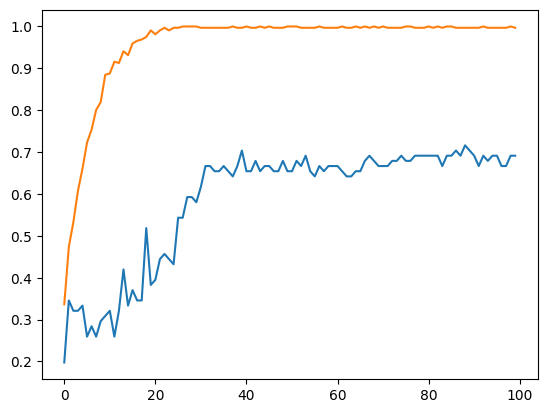

In [ ]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.show()

## Gráficos de variação do `val_loss` e `loss`

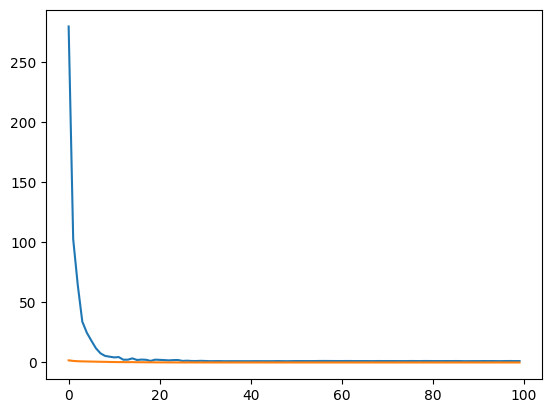

In [ ]:
# Gera os gáficos a partir as perdas obtidas pelo treinamento
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.show()

## Matriz de Confusão

In [ ]:
# obtém as saídas reais do modelo treinado, recebendo o cj. de teste como entrada
y_pred = model.predict(X_test)

# converte para números inteiros as saídas desejadas e saídas da predição
y_pred_int = y_pred.argmax(axis=1)
y_test_int = y_test.argmax(axis=1)

3/3 [==============================] - 0s 74ms/step


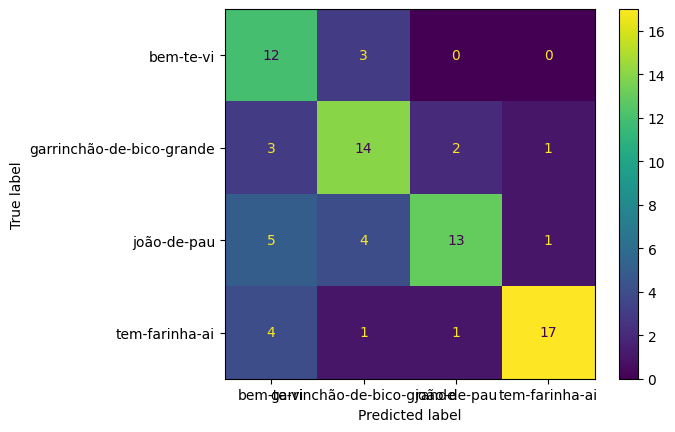

In [ ]:
# Gera matriz de confusão a partir dos resultados do treino
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_int, y_pred_int), display_labels=classes_dict).plot()
plt.grid(False)
plt.show()

Em nossa matriz de confusão conseguimos ver que o modelo conseguiu acertar bem suas classes de validação, tendo em suas diagonais sempre o maior valor da linha.

## Relatório de classificação

In [ ]:
print(classification_report(y_test_int, y_pred_int))

              precision    recall  f1-score   support

           0       0.50      0.80      0.62        15
           1       0.64      0.70      0.67        20
           2       0.81      0.57      0.67        23
           3       0.89      0.74      0.81        23

    accuracy                           0.69        81
   macro avg       0.71      0.70      0.69        81
weighted avg       0.73      0.69      0.70        81



# Resultados

Tivemos uma acurácia aproximada de 99,5% em nossos dados de treinamento e 66,6% em nossos dados de validação.

Acreditamos que alguns fatores influenciaram para essa porcentagem nos dados de validação não fosse maior:
- A quantidade de dados que treinamos o modelo, por necessidades computacionais, foi reduzido para um número bem inferior do que seria necessário para um modelo mais robusto (usamos cerca de 105 arquivos para cada classe)
